# Tugas Modul Convolutional Neural Network

## MobileNet

### Import Library
- Tahap pertama adalah import seluruh library yang dibutuhkan


In [47]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers # type: ignore
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten # type: ignore

### Load Data
- Load dataset berdasarkan path dimana dataset disimpan

In [48]:
count = 0
dirs = os.listdir(r'D:\Funiversity\Sem5\ML\M06\Tugas6_B_11957\train_data')

for dir in dirs:
    files = list(os.listdir(r'D:\Funiversity\Sem5\ML\M06\Tugas6_B_11957\train_data/'+dir))
    print(dir+' Folder has '+str(len(files))+' Images')
    count = count + len(files)

print('Images Folder has '+str(count)+' Images')

Matang Folder has 800 Images
Mentah Folder has 800 Images
Images Folder has 1600 Images


### Load Images into Arrays as Dataset
- Membuat dataset dari gambar yang ada di direktori

In [49]:
base_dir = r'D:\Funiversity\Sem5\ML\M06\Tugas6_B_11957\train_data'
img_size = 180
batch = 32
validation_split = 0.1

- Memasukkan parameter yang telah di definisikan tadi untuk membuat dataset dari gambar di direktori


In [50]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed = 123,
    image_size = (img_size, img_size),
    batch_size = batch,
)

Found 1600 files belonging to 2 classes.


In [51]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Matang', 'Mentah']


### Train-Validation-Test Split
- Membagi dataset menjadi tiga subset yaitu train, validation, dan test
    - Train, digunakan untuk melatih model agar mengenali pola dalam data
    - Validation, digunakan untuk mengevaluasi performa model selama pelatihan
    - Test, digunakan untuk menguji model setelah pelatihan

In [52]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 50
Train Images: 45
Validation Images: 5


In [53]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

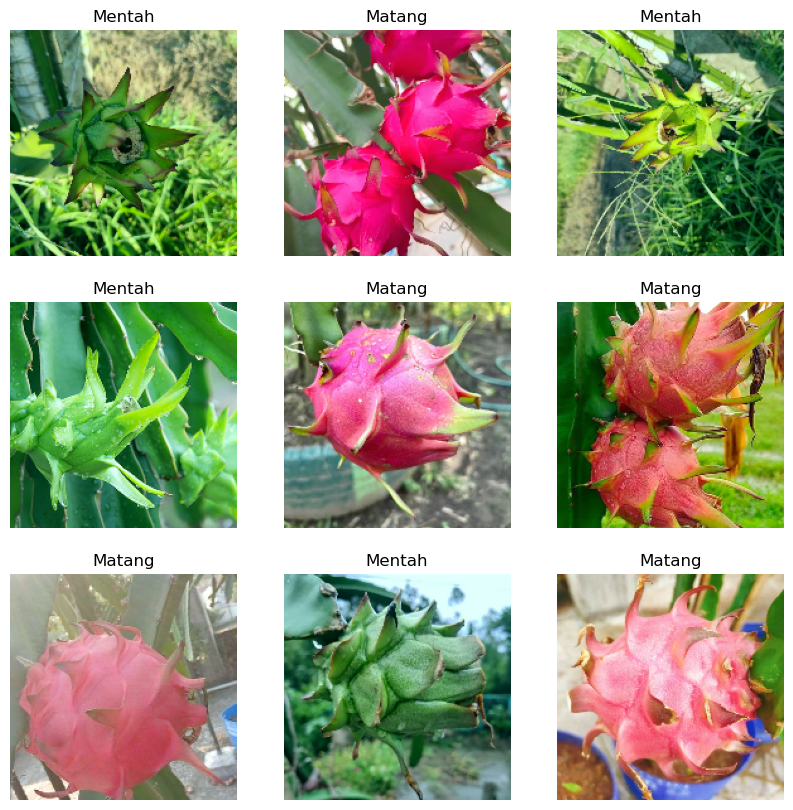

In [54]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize = (10,10))


for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [55]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 180, 180, 3)


In [56]:
AUTOTUNE = tf.data.AUTOTUNE

In [57]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [58]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

### Data Augmentation
- Digunakan untuk menambah variasi data pelatihan dengan membuat gambar baru dari yang sudah ada seperti dengan rotasi, flipping, zooming, dan sebagainy
- Untuk mengurangi overfitting dan memperbesar dataset tanpa mengumpulkan data baru

In [59]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

c:\Users\M S I\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


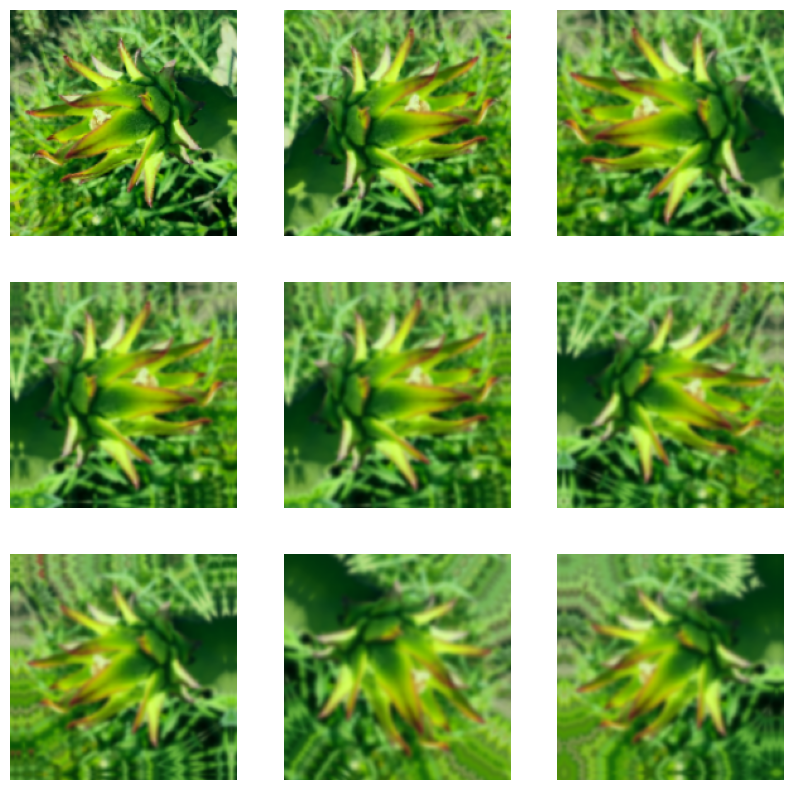

In [60]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

### MobileNet
- Salah satu algoritma yang dirancang untuk perangkat dengan keterbatasan sumber daya seperti smartphone

In [61]:
from tensorflow.keras.applications import MobileNet # type: ignore
from tensorflow.keras.models import Model # type: ignore

base_model = MobileNet(include_top = False, input_shape = (img_size, img_size, 3))

base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(len(class_names), activation = 'softmax')
])

C:\Users\M S I\AppData\Local\Temp\ipykernel_1408\188506427.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top = False, input_shape = (img_size, img_size, 3))


In [62]:
from tensorflow.keras.optimizers import Adam # type: ignore

model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [63]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,322 (12.82 MB)

 Trainable params: 3,069,314 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [64]:
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3,
    mode = 'max'
)

history= model.fit(
    train_ds,
    epochs = 30,
    validation_data = val_ds,
    callbacks = [early_stopping]
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.7462 - loss: 0.4981 - val_accuracy: 0.9500 - val_loss: 0.1282
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - accuracy: 0.9709 - loss: 0.0843 - val_accuracy: 0.9563 - val_loss: 0.0823
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.9868 - loss: 0.0463 - val_accuracy: 0.9750 - val_loss: 0.0634
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.9889 - loss: 0.0282 - val_accuracy: 0.9937 - val_loss: 0.0123
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 400ms/step - accuracy: 0.9956 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 642ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - accuracy: 0.9988 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accu

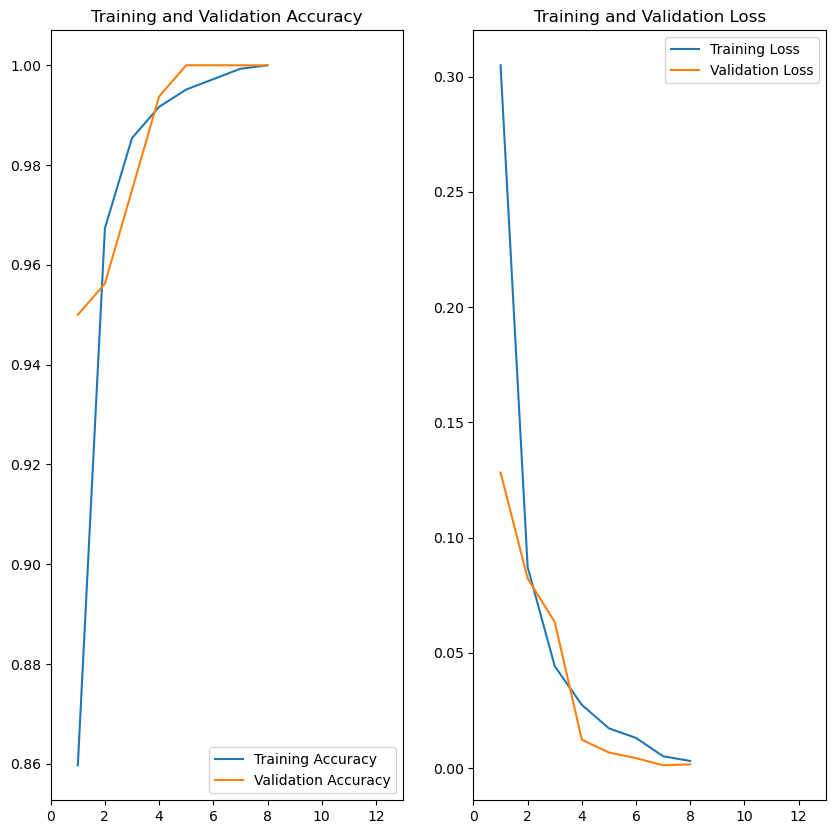

In [65]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize = (10, 10))

plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label = 'Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label = 'Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [66]:
model.save('model_mobilenet.h5')

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model # type: ignore
from PIL import Image

model = load_model(r'D:\Funiversity\Sem5\ML\M06\Tugas6_B_11957\model_mobilenet.h5')
class_names = ['Matang', 'Mentah']

def classify_images(image_path, save_path = 'predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size = (180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'D:\Funiversity\Sem5\ML\M06\Tugas6_B_11957\test_data\Matang\Mature_Dragon_Original_Data0007.jpg', save_path = 'matang.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Prediksi: Matang
Confidence: 73.11%
Prediksi: Matang dengan confidence 73.11%. Gambar asli disimpan di matang.jpg.


Found 80 files belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


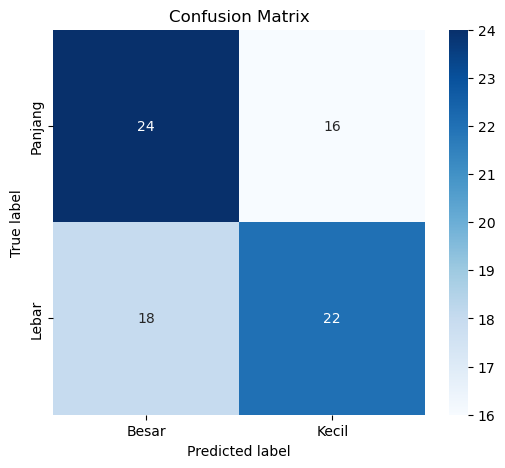

Confusion Matrix:
 [[24 16]
 [18 22]]
Akurasi: 0.575
Presisi: [0.57142857 0.57894737]
Recall: [0.6  0.55]
F1 Score: [0.58536585 0.56410256]


In [71]:
import tensorflow as tf
from tensorflow.keras.models import load_model # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt

mobileNet_model = load_model(r'D:\Funiversity\Sem5\ML\M06\Tugas6_B_11957\model_mobilenet.h5')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 32,
    image_size = (180, 180)
)

y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis = 1)

true_labels = []

for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())

true_labels = tf.convert_to_tensor(true_labels)

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))

sns.heatmap(
    conf_mat.numpy(),
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    xticklabels = ["Besar", "Kecil"],
    yticklabels = ["Panjang", "Lebar"]
)

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
